# Pancreas pipeline with query cell type annotation

In this notebook, we are going to integrate 5 different pancreas datasets with scNet's pipeline. 

First, we load all 5 pancreas datasets and separate query and reference datasets. Next, we train a network on 3 pancreas datasets (3 reference datasets). Then, we will perform architecture surgery and add 2 more condition to the network (2 query conditions). In the next step, we will fine-tune the new scNet network on 2 other pancreas datasets which we call them query datasets. Finally, we use MMD latent projection of 5 integrated datasets to annotate cell types of query cells with weighted KNN. 

In general, scNet's pipeline consists of the following steps:

1. Load & Pre-process the reference datasets
2. Train scNet with reference datasets
    - Qualitatively evaluate trained scNet with MMD space reference projection UMAPs
3. Load & Pre-process the query datasets
4. Perform architecture surgery and add query conditions 
5. Train new scNet network (which has much less trainable parameters) on query datasets
    - Qualitatively evaluate trained scNet with MMD space query projection UMAPs
    - Qualitatively evaluate trained scNet with MMD space query&reference projection UMAPs
6. Annotate cell types of query cells by training weighted KNN on MMD latent projection of reference datasets.

In [1]:
import os
os.chdir("../")

In [2]:
import scnet as sn
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sc.settings.set_figure_params(dpi=80, frameon=False, facecolor='white')

Using TensorFlow backend.


In [3]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Pancreas SS2", "Pancreas CelSeq2"]

## Loading 5 Pancreas datasets and data preparation

In [4]:
adata = sn.data.read("/home/mohsen/data/pancreas/pancreas_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 15681 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## Number of cells in each batch

In [5]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8391
Pancreas SS2            2961
Pancreas CelSeq2        2426
Pancreas CelSeq         1271
Pancreas Fluidigm C1     632
Name: study, dtype: int64

## Now we separate query(target) and reference(source) datasets

In [6]:
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
source_adata

View of AnnData object with n_obs × n_vars = 10294 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [7]:
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
target_adata

View of AnnData object with n_obs × n_vars = 5387 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## Train/Test Split

In [8]:
train_adata, valid_adata = sn.utils.train_test_split(
    source_adata, 0.80)

In [9]:
train_adata.shape, valid_adata.shape

((8235, 1000), (2059, 1000))

In [10]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_conditions

3

## Create & Train model with training data

In [11]:
network = sn.models.scNet(task_name='pancreas_reference',
                          x_dimension=train_adata.shape[1], 
                          z_dimension=10,
                          architecture=[128, 64, 32],
                          n_conditions=n_conditions,
                          lr=0.001,
                          alpha=0.00005,
                          beta=1000.0,
                          eta=1.0,
                          use_batchnorm=False,
                          clip_value=1000.0,
                          loss_fn='sse',
                          model_path="./models/scNet/",
                          dropout_rate=0.05,
                          output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
scNet's network has been successfully constructed!
scNet's network has been successfully compiled!


## We assign each study to a numerical label 

In [12]:
network.model_path

'./models/scNet/pancreas_reference'

In [13]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = sn.utils.create_condition_encoder(conditions, target_conditions)
condition_encoder

{'Pancreas inDrop': 0, 'Pancreas CelSeq': 1, 'Pancreas Fluidigm C1': 2}

In [14]:
network.set_condition_encoder(condition_encoder)

## Training the network

In [18]:
network.train(train_adata,
              valid_adata,
              condition_key=condition_key,
              n_epochs=1000,
              batch_size=1024,
              early_stop_limit=10,
              lr_reducer=7,
              save=True,
              retrain=True,
              verbose=3)

Instructions for updating:
Use tf.cast instead.
 |███████████---------| 59.6%  - loss: 1014.2877 - reconstruction_loss: 970.4787 - mmd_loss: 43.8089 - val_loss: 1023.3326 - val_reconstruction_loss: 955.5753 - val_mmd_loss: 67.757388
scNet has been successfully saved in ./models/scNet/pancreas_reference.


In [16]:
network.condition_encoder

{'Pancreas inDrop': 0, 'Pancreas CelSeq': 1, 'Pancreas Fluidigm C1': 2}

In [17]:
encoder_labels, _ = sn.utils.label_encoder(
    train_adata, le=network.condition_encoder, condition_key=condition_key)

In [18]:
latent_adata = network.to_mmd_layer(train_adata, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 8235 × 32 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [19]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

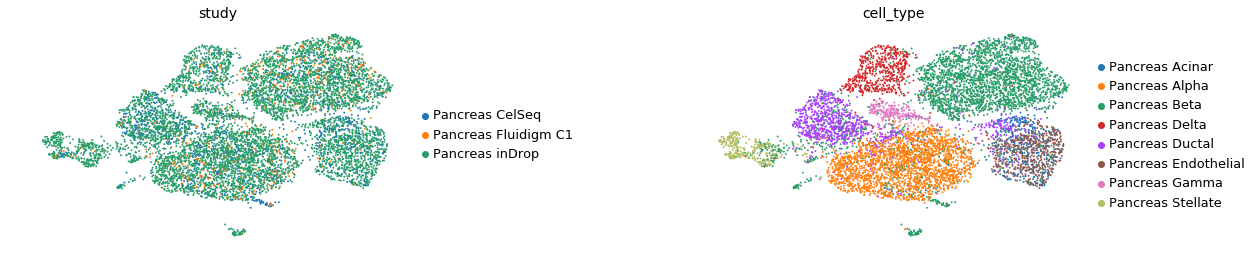

In [20]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], 
           frameon=False, wspace=0.6)

## Perfrom architecture Surgery (scNet v1)

In [21]:
new_network = sn.operate(network,
                         new_task_name="pancreas_query",
                         new_conditions=target_conditions,
                         init='Xavier', 
                         freeze=True,
                         freeze_expression_input=False,
                         remove_dropout=False)

scNet's network has been successfully constructed!
scNet's network has been successfully compiled!
scNet's network has been successfully compiled!


In [22]:
new_network.condition_encoder

{'Pancreas inDrop': 0,
 'Pancreas CelSeq': 1,
 'Pancreas Fluidigm C1': 2,
 'Pancreas SS2': 3,
 'Pancreas CelSeq2': 4}

## Train with query datasets

In [23]:
new_network.model_path

'./models/scNet/pancreas_query'

In [24]:
train_adata, valid_adata = sn.utils.train_test_split(target_adata, 0.80)

In [25]:
train_adata.shape, valid_adata.shape

((4309, 1000), (1078, 1000))

In [24]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  n_epochs=1000,
                  batch_size=1024, 
                  early_stop_limit=20,
                  lr_reducer=15,
                  save=True, 
                  retrain=True,
                  verbose=3)

Instructions for updating:
Use tf.cast instead.
 |██------------------| 12.8%  - loss: 1142.2990 - reconstruction_loss: 1135.9812 - mmd_loss: 6.3178 - val_loss: 1093.9601 - val_reconstruction_loss: 1083.8430 - val_mmd_loss: 10.1170
scNet has been successfully saved in ./models/scNet/pancreas_query.


## Projecting target data in to the latent space of the model 

In [30]:
encoder_labels, _ = sn.utils.label_encoder(target_adata, 
                                           le=new_network.condition_encoder, condition_key=condition_key)

In [31]:
target_adata.obs[condition_key].value_counts()

Pancreas SS2        2961
Pancreas CelSeq2    2426
Name: study, dtype: int64

In [32]:
latent_adata = new_network.to_mmd_layer(target_adata, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 5387 × 32 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [33]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

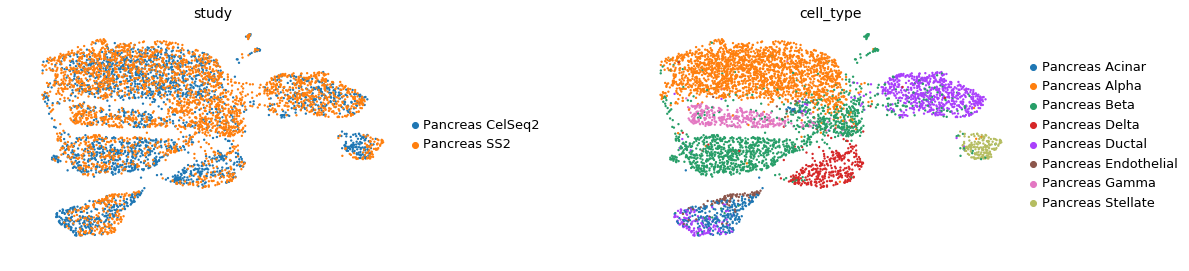

In [34]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], 
           wspace=0.5, frameon=False)

## Projecting query+reference data in to the MMD latent space

In [35]:
encoder_labels, _ = sn.utils.label_encoder(adata, 
                                           le=new_network.condition_encoder,
                                           condition_key=condition_key)

In [36]:
latent_adata = new_network.to_mmd_layer(adata, encoder_labels, encoder_labels)

In [37]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

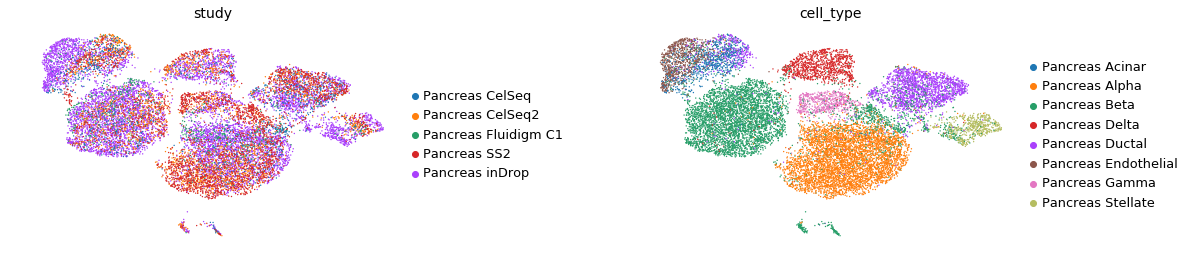

In [38]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], 
           wspace=0.5, frameon=False)

## Weighted KNN

In [39]:
n_neighbors = 20
threhsold = 0.5

### Project reference data in MMD latent space

In [40]:
encoder_labels, _ = sn.utils.label_encoder(source_adata, 
                                           le=new_network.condition_encoder, 
                                           condition_key=condition_key)

In [41]:
train_latent = new_network.to_mmd_layer(source_adata, encoder_labels, encoder_labels)

### Project query data in MMD latent space

In [42]:
encoder_labels, _ = sn.utils.label_encoder(target_adata, 
                                           le=new_network.condition_encoder, 
                                           condition_key=condition_key)

In [43]:
valid_latent = new_network.to_mmd_layer(target_adata, encoder_labels, encoder_labels)

In [44]:
sc.pp.neighbors(valid_latent)
sc.tl.umap(valid_latent)

In [45]:
prediction, uncertainties = sn.ann.weighted_knn(train_latent, 
                                                valid_latent,
                                                cell_type_key,
                                                n_neighbors=n_neighbors,
                                                threshold=threhsold,
                                                pred_unknown=True,
                                                return_uncertainty=True
                                                )
prediction = prediction.reshape(-1,)

Weighted KNN with n_neighbors = 20 and threshold = 0.5 ... finished!


In [46]:
true_labels = np.array(valid_latent.obs[cell_type_key].values)
true_labels = true_labels.reshape(-1,)

In [47]:
labels_eval = prediction.reshape(-1,) == np.array(true_labels)
labels_eval = labels_eval.astype(object)

n_correct = len(labels_eval[labels_eval == True])
n_incorrect = len(labels_eval[labels_eval == False]) - len(labels_eval[prediction == 'Unknown'])
n_unknown = len(labels_eval[prediction == 'Unknown'])

labels_eval[labels_eval == True] = f'Correct ({n_correct})'
labels_eval[labels_eval == False] = f'InCorrect ({n_incorrect})'
labels_eval[prediction == 'Unknown'] = f'Unknown ({n_unknown})'

In [48]:
valid_latent.obs['prediction'] = prediction.reshape(-1,)
valid_latent.obs['uncertainty'] = uncertainties.reshape(-1,)
valid_latent.obs['evaluation'] = labels_eval

... storing 'prediction' as categorical
... storing 'evaluation' as categorical


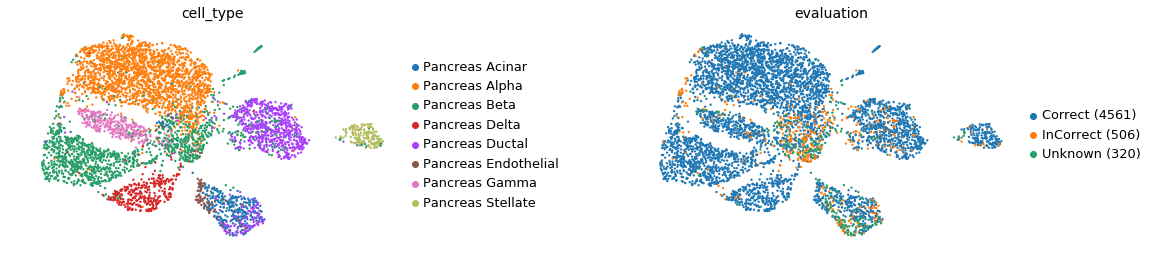

In [49]:
sc.pl.umap(valid_latent, color=[cell_type_key, 'evaluation'], wspace=0.5, frameon=False)

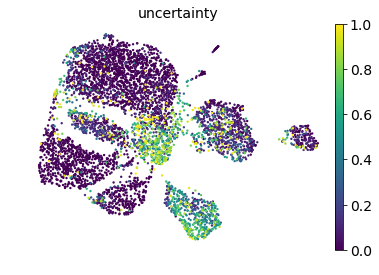

In [50]:
sc.pl.umap(valid_latent, color='uncertainty', frameon=False)

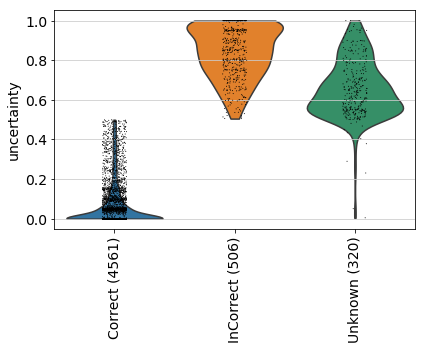

In [51]:
sc.pl.violin(valid_latent, keys='uncertainty', groupby='evaluation', rotation=90)

## More visualization 

In [52]:
cell_types = valid_latent.obs[cell_type_key].unique().tolist()

In [53]:
results_df = pd.DataFrame(columns=['cell type', 'Correct', 'InCorrect', 'Unknown'])
for cell_type in cell_types:
    labels_eval_key = f'prediction'

    cell_latent = valid_latent[valid_latent.obs[cell_type_key] == cell_type]

    pred_labels = cell_latent.obs[labels_eval_key].values
    true_labels = cell_latent.obs[cell_type_key].values

    labels_eval = np.array(pred_labels) == np.array(true_labels)

    n_correct = len(labels_eval[labels_eval == True])
    n_incorrect = len(labels_eval[labels_eval == False]) - len(labels_eval[pred_labels == 'Unknown'])
    n_unknown = len(labels_eval[pred_labels == 'Unknown'])
    
    new_row = {"cell type": f"{cell_type} ({cell_latent.shape[0]})"}

    new_row['Correct'] = n_correct
    new_row['InCorrect'] = n_incorrect
    new_row['Unknown'] = n_unknown

    results_df = results_df.append(new_row, ignore_index=True)

In [54]:
results_df = results_df.sort_values('Correct', ascending=False)
results_df_melted = pd.melt(results_df, id_vars=['cell type'], var_name='type', value_name='n_samples')

In [55]:
sns.set(style='whitegrid')
color_palette = sns.color_palette("cubehelix", 3)

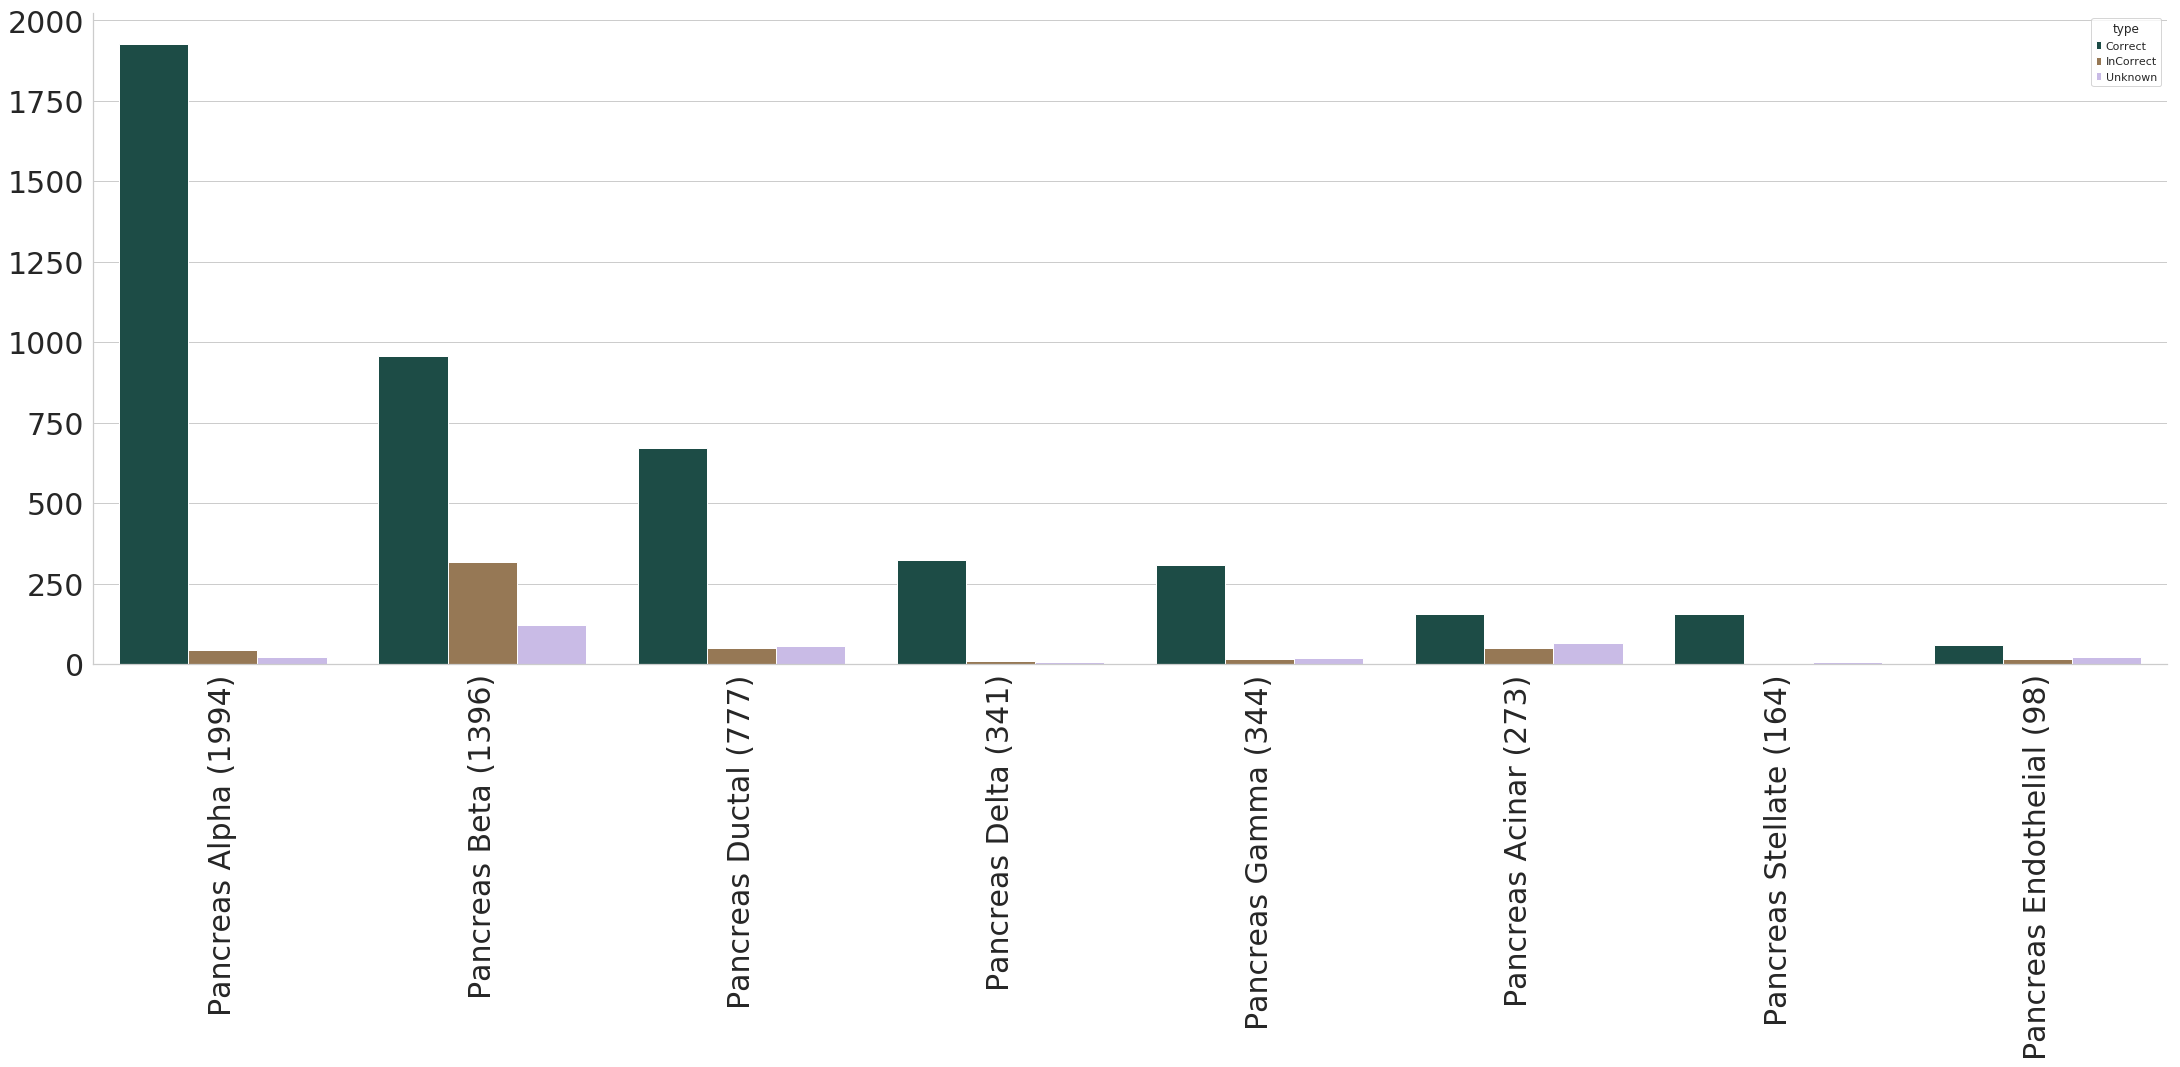

In [56]:
barplot = sns.catplot(x='cell type', y='n_samples', hue='type', data=results_df_melted, 
                      kind='bar', height=10, aspect=3, legend_out=False, palette=color_palette)


plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("")
plt.xlabel("")
plt.show()
plt.close()